In [64]:
# Import Dependencies
#%matplotlib notebook
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
#import additional dependencies
import numpy as np
import pandas as pd

import datetime as dt
from datetime import datetime

In [4]:

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#Try this
from sqlalchemy import cast, Date

In [5]:
# Create a new engine instance
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()



['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)


In [7]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


<font size="5">Experiment with Data</font>

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#date=session.query(Measurement.date).first()
#station=session.query(Measurement.station).order_by(Measurement.date.desc()).first()

max_date = max_date[0]
max_date

#Test Print
#for day in date:
    #print(day)

'2017-08-23'

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Get the first element of the tuple
max_date = max_date[0]
#print(max_date)

# Calculate the date 1 year ago from today
# The days are equal 366 so that the first day of the year is included
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)
#print(year_ago)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
#print(query)


# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])
#len(precipitation_df)

# Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')
# Set index to date
precipitation_df.set_index('date', inplace=True)
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)

precipitation_df.head(5)

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [34]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
#print(available_stations)
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#active_stations = session.query(Measurement.station).count()
#active_stations=session.query(Measurement.station).group_by()

#Why is function.count not working?
#active_stations=session.query(Measurement.station, fun.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(desc('count'))
#active_stations

active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station=active_stations[0][0]

#most_active_station
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

#most_active_temps
print("Most Active Station Temperatures")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2],2)}")




Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.66


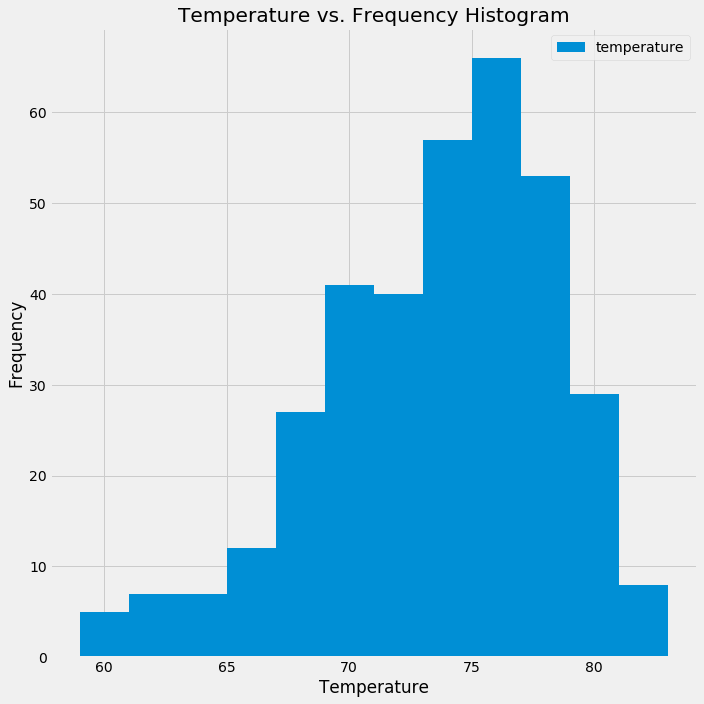

In [76]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

#most_temps_station

most_temps_station= most_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temps_station_12months = session.query(Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()

#Convert to dataframe
most_temps_station_12mo_df = pd.DataFrame(most_temps_station_12months,columns=['temperature'])
most_temps_station_12mo_df.head()

#set plot size
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

# Use 12 bins since the observation is for twelve months
most_temps_station_12mo_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.xlabel('Temperature')
plt.tight_layout()
plt.savefig("TemperaturevsFrequency.png")
plt.show()
